In [1]:
import numpy as np

In [2]:
from jobflow import job, Flow

/home/geiger_j/.aiida_venvs/adis/lib/python3.10/site-packages/paramiko/pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
/home/geiger_j/.aiida_venvs/adis/lib/python3.10/site-packages/paramiko/transport.py:253: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


In [3]:
from pyiron_base import Project

In [4]:
from python_workflow_definition.jobflow import write_workflow_json

In [5]:
from python_workflow_definition.pyiron_base import load_workflow_json

In [6]:
from quantum_espresso_workflow import (
    calculate_qe as _calculate_qe, 
    generate_structures as _generate_structures, 
    get_bulk_structure as _get_bulk_structure, 
    plot_energy_volume_curve as _plot_energy_volume_curve,
)

In [7]:
workflow_json_filename = "jobflow_to_pyiron_base_qe.json"

In [8]:
calculate_qe = job(_calculate_qe, data=["energy", "volume", "structure"])
generate_structures = job(_generate_structures, data=[f"s_{i}" for i in range(100)])
plot_energy_volume_curve = job(_plot_energy_volume_curve)
get_bulk_structure = job(_get_bulk_structure)

In [9]:
pseudopotentials = {"Al": "Al.pbe-n-kjpaw_psl.1.0.0.UPF"}

In [10]:
structure = get_bulk_structure(
    element="Al",
    a=4.05,
    cubic=True,
)

In [11]:
calc_mini = calculate_qe(
    working_directory="mini",
    input_dict={
        "structure": structure.output,
        "pseudopotentials": pseudopotentials,
        "kpts": (3, 3, 3),
        "calculation": "vc-relax",
        "smearing": 0.02,
    },
)

In [12]:
number_of_strains = 5
structure_lst = generate_structures(
    structure=calc_mini.output.structure,
    strain_lst=np.linspace(0.9, 1.1, number_of_strains),
)

In [13]:
job_strain_lst = []
for i in range(number_of_strains):
    calc_strain = calculate_qe(
        working_directory="strain_" + str(i),
        input_dict={
            "structure": getattr(structure_lst.output, f"s_{i}"),
            "pseudopotentials": pseudopotentials,
            "kpts": (3, 3, 3),
            "calculation": "scf",
            "smearing": 0.02,
        },
    )
    job_strain_lst.append(calc_strain)

In [14]:
plot = plot_energy_volume_curve(
    volume_lst=[job.output.volume for job in job_strain_lst],
    energy_lst=[job.output.energy for job in job_strain_lst],
)

In [15]:
flow = Flow([structure, calc_mini, structure_lst] + job_strain_lst + [plot])

In [16]:
write_workflow_json(flow=flow, file_name=workflow_json_filename)

In [17]:
!cat {workflow_json_filename}

───────┬────────────────────────────────────────────────────────────────────────
       │ File: workflow_qe_jobflow.json
───────┼────────────────────────────────────────────────────────────────────────
   1   │ {"nodes": {"0": "quantum_espresso_workflow.get_bulk_structure", "1": "q
       │ uantum_espresso_workflow.calculate_qe", "2": "quantum_espresso_workflow
       │ .generate_structures", "3": "quantum_espresso_workflow.calculate_qe", "
       │ 4": "quantum_espresso_workflow.calculate_qe", "5": "quantum_espresso_wo
       │ rkflow.calculate_qe", "6": "quantum_espresso_workflow.calculate_qe", "7
       │ ": "quantum_espresso_workflow.calculate_qe", "8": "quantum_espresso_wor
       │ kflow.plot_energy_volume_curve", "9": "Al", "10": 4.05, "11": true, "12
       │ ": "mini", "13": "python_workflow_definition.shared.get_dict", "14": {"
       │ Al": "Al.pbe-n-kjpaw_psl.1.0.0.UPF"}, "15": [3, 3, 3], "16": "vc-relax"
       │ , "17": 0.02, "18": [0.9, 0.9500000000000001, 1.0, 1.05, 1.1

In [18]:
pr = Project("test")
pr.remove_jobs(recursive=True, silently=True)

0it [00:00, ?it/s]

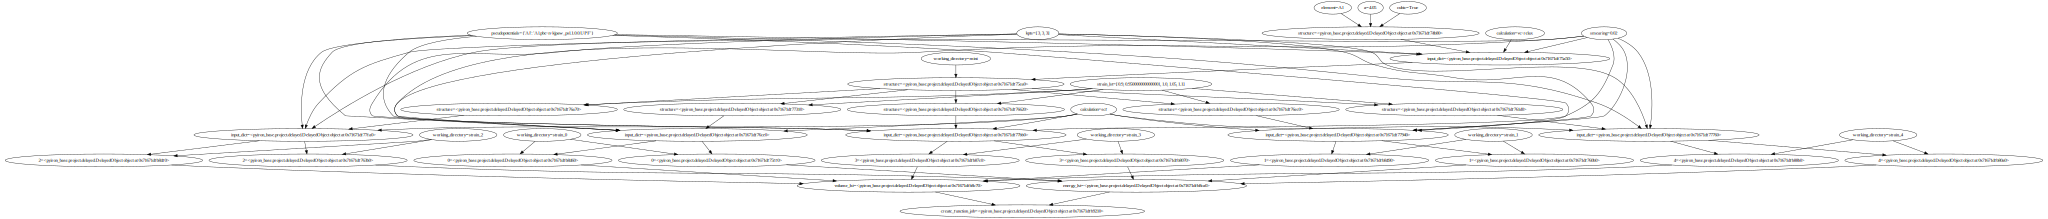

In [19]:
delayed_object = load_workflow_json(project=pr, file_name=workflow_json_filename)
delayed_object.draw()

The job get_bulk_structure_f1e730ed97e30e5439e855d2ac41396f was saved and received the ID: 2
The job get_dict_09572c95c87e234a9d89925d32a56d9a was saved and received the ID: 3
The job calculate_qe_84bdb06f45f0b9a17b7e2a73ecc8d2da was saved and received the ID: 4
FROM ASE
Atoms(symbols='Al4', pbc=True, cell=[4.05, 4.05, 4.05])
['Al', 'Al', 'Al', 'Al']
{'Al': 'Al.pbe-n-kjpaw_psl.1.0.0.UPF'}
The job generate_structures_63908661a41bfbc45ce757d9ffa40e3f was saved and received the ID: 5
The job get_dict_297af5b8fe25076b5c034f7cb6f1074c was saved and received the ID: 6
The job calculate_qe_97c1e53609c43812b9ec6060abfcffb8 was saved and received the ID: 7
FROM ASE
Atoms(symbols='Al4', pbc=True, cell=[3.906019955258373, 3.906019955258373, 3.906019955258373])
['Al', 'Al', 'Al', 'Al']
{'Al': 'Al.pbe-n-kjpaw_psl.1.0.0.UPF'}
The job get_dict_19b5149eec0ab66b20e71b1d7555b26a was saved and received the ID: 8
The job calculate_qe_72f8caf9c063301570f963aceb3e62a4 was saved and received the ID: 9
FROM A

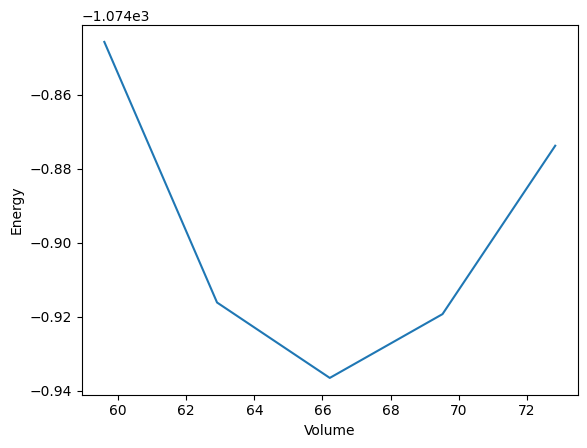

In [20]:
delayed_object.pull()